In [ ]:
import pandas as pd
import os

spread_df = pd.read_csv('/Users/jeremyg/Documents/GitHub/SummerIndependentProject/tickData/spreadData/EHF_spread.csv', index_col=0)
# change the column name 0 to spread
spread_df.columns = ['spread']
spread_df.index = pd.to_datetime(spread_df.index)
spread_df

In [ ]:
stockPath = "../tickData/stocks/1319"
stockFiles = os.listdir(stockPath)
futuresPath = "../tickData/futuresOB/EHF"
futuresFiles = os.listdir(futuresPath)

stockData = pd.DataFrame()
futuresData =  pd.DataFrame()
for file in stockFiles:
  stockTick = pd.read_csv(os.path.join(stockPath,file), compression='gzip', index_col=0)
  stockTick['timestamp'] = pd.to_datetime(stockTick.date.astype(str) + ' ' + stockTick.time.astype(str), format="%Y-%m-%d %H%M%S%f")
  stockData = pd.concat([stockData, stockTick], axis=0, ignore_index=True)
# for file in futuresFiles:
#   futuresData[file] = os.listdir(futuresPath + '/' + file)
# sort by timestamp
stockData = stockData.sort_values(by=['timestamp'])
# reindex with timestamp
stockData = stockData.set_index('timestamp')
stockData

In [ ]:
for file in futuresFiles:
  if file.endswith('.gz'):
    futuresTick = pd.read_csv(os.path.join(futuresPath,file), compression='gzip')
  else:
    futuresTick = pd.read_csv(os.path.join(futuresPath,file))
  futuresTick['timestamp'] = pd.to_datetime(futuresTick.date.astype(str) + ' ' + futuresTick.time.astype(str), format="%Y-%m-%d %H%M%S%f")
  futuresData = pd.concat([futuresData, futuresTick], axis=0, ignore_index=True)
# sort by timestamp
futuresData = futuresData.sort_values(by=['timestamp'])
# reindex with timestamp
futuresData = futuresData.set_index('timestamp')
futuresData

In [ ]:
dates = list(set(pd.to_datetime(stockData.date)))
dates = sorted(dates)

In [ ]:
def valid_date_n_days_later(start, dates, n):
    i = 1
    while i <= n:
        start = start + pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start > dates[-1]:
            return False
    return start

def valid_date_n_days_before(start, dates, n):
    i = 1
    while i <= n:
        start = start - pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start < dates[0]:
            return False
    return start

## Original Strategy

In [ ]:
import numpy as np
date = dates[20]
# stockDataDate = stockData[stockData.date == date]
# futuresDataDate = futuresData[futuresData.date == date]

train_date = valid_date_n_days_before(date, dates, 20)
end_date = valid_date_n_days_later(date, dates, 1)
start_time = date + pd.DateOffset(hours=9)
spread_historical_data = spread[train_date:date]
spread_signal_data = spread[start_time:end_date]
sd = np.std(spread_historical_data['spread'], axis=0)
mean = spread_historical_data['spread'].mean()
upper = mean + 1.5 * sd
lower = mean - 1.5 * sd
spread_signal_data['signal'] = np.where(spread_signal_data['spread'] > upper, 1, np.where(spread_signal_data['spread'] < lower, -1, 0))
spread_signal_data

In [163]:
from tqdm import tqdm


pnl_daily = {}
# stockDataDate = stockData[stockData.date == date]
# futuresDataDate = futuresData[futuresData.date == date]
for date in tqdm(dates[20:50]):

    train_date = valid_date_n_days_before(date, dates, 20)
    end_date = valid_date_n_days_later(date, dates, 1)
    start_time = date + pd.DateOffset(hours=9)
    spread_historical_data = spread_df[train_date:date]
    sd = np.std(spread_historical_data['spread'], axis=0)
    mean = spread_historical_data['spread'].mean()
    upper = mean + 1.5 * sd
    lower = mean - 1.5 * sd

    stock_trade_data = stockData[start_time:end_date]
    future_trade_data = futuresData[start_time:end_date]
    # position 1 for long spread, -1 for short spread, 0 for no position
    position = 0
    # net position in dollar
    net_position = 0
    # shares of stock
    stock_position = 0
    # shares of future
    future_position = 0
    timestamp = start_time + pd.DateOffset(minutes=5)
    while timestamp <= stock_trade_data.index[-1]:
        # print(timestamp)
        if timestamp >= stock_trade_data.index[-1] or timestamp >= future_trade_data.index[-1]:
            # print(net_position, stock_position, future_position)
            stock_row = stock_trade_data.iloc[-1]
            future_row = future_trade_data.iloc[-1]
            if position == 1:
                net_position = net_position - stock_position * stock_row.SP1 + future_position * future_row.bidPrice1 * 2
            if position == -1:
                net_position = net_position + stock_position * stock_row.BP1 - future_position * future_row.askPrice1 * 2
            break
        row = stock_trade_data.loc[stock_trade_data.index >= timestamp].iloc[0]
        stock_mid_quote = (row['SP1'] + row['BP1']) / 2
        future_last_row = (future_trade_data.loc[future_trade_data.index <= timestamp]).iloc[-1]
        future_mid_quote = (future_last_row['askPrice1'] + future_last_row['bidPrice1']) / 2
        spread = np.log(stock_mid_quote) - np.log(future_mid_quote)
        future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
        # print(timestamp)
        if stock_position == 0 and future_position == 0:
            # print(1)
            if spread >= upper:
                # print(1.1)
                if position >= 0:
                    if row['BV1'] >=2:
                        position = 1
                        stock_position = stock_position - 2
                        future_position = future_position + 1
                        net_position = net_position - row['BP1'] * 2 + future_next_row['askPrice1'] * 1 * 2
                        timestamp = future_next_row.name
                        continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            elif spread <= lower:
                # print(1.2)
                if position <= 0:
                    if row['SV1'] >=2:
                        position = -1
                        stock_position = stock_position + 2
                        future_position = future_position - 1
                        net_position = net_position + row['SP1'] * 2 - future_next_row['bidPrice1'] * 1 * 2
                        timestamp = future_next_row.name
                        continue
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
            else:
                # print(1.3)
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                # print(next_row.name)
                timestamp = next_row.name
        else:
            # print(2)
            # print(position)
            if position == 1:
                if spread <=mean:
                    while stock_position != 0 or future_position !=0:
                        if stock_position != 0:
                            remained = min(stock_position + row['SV1'], 0)
                            net_position = net_position + row['SP1'] * (remained - stock_position)
                            stock_position = remained
                        if future_position != 0:
                            remained = max(future_position - future_next_row['bidSize1'], 0)
                            net_position = net_position - future_next_row['bidPrice1'] * (future_position - remained) * 2
                            future_position = remained
                        timestamp = future_next_row.name
                        if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                            break
                        row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                        timestamp = row.name
                        future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            elif position == -1:
                if spread >=mean:
                    while stock_position != 0 or future_position !=0:
                        if stock_position != 0:
                            remained = max(stock_position - row['BV1'], 0)
                            net_position = net_position - row['BP1'] * (stock_position - remained)
                            stock_position = remained
                        if future_position != 0:
                            remained = min(future_position + future_next_row['askSize1'], 0)
                            net_position = net_position + future_next_row['askPrice1'] * (remained - future_position) * 2
                            future_position = remained
                        timestamp = future_next_row.name
                        if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                            break
                        row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                        timestamp = row.name
                        future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                else:
                    next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                    timestamp = next_row.name
            else:
                next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                timestamp = next_row.name
    pnl_daily[date] = net_position

# plot pnl
pnl = pd.Series(pnl_daily)
print(pnl)

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/7m/3z46bhfd6nb595vppqzckghh0000gn/T/ipykernel_4991/1039864505.py:44: RuntimeWarning: divide by zero encountered in log
  spread = np.log(stock_mid_quote) - np.log(future_mid_quote)
 40%|████      | 12/30 [01:13<01:14,  4.14s/it]/var/folders/7m/3z46bhfd6nb595vppqzckghh0000gn/T/ipykernel_4991/1039864505.py:44: RuntimeWarning: invalid value encountered in scalar subtract
  spread = np.log(stock_mid_quote) - np.log(future_mid_quote)
100%|██████████| 30/30 [03:09<00:00,  6.30s/it]

2020-07-29    14070.0
2020-07-30    14965.0
2020-07-31      110.0
2020-08-03      140.0
2020-08-04        0.0
2020-08-05       30.0
2020-08-06      580.0
2020-08-07       80.0
2020-08-10      280.0
2020-08-11    -7330.0
2020-08-12     1640.0
2020-08-13      285.0
2020-08-14     8620.0
2020-08-17      100.0
2020-08-18      380.0
2020-08-19      490.0
2020-08-20     1480.0
2020-08-21    14530.0
2020-08-24       70.0
2020-08-25     1690.0
2020-08-26      690.0
2020-08-27      440.0
2020-08-28    15810.0
2020-08-31      180.0
2020-09-01    20055.0
2020-09-02     1370.0
2020-09-04    16760.0
2020-09-07    16000.0
2020-09-08     5020.0
2020-09-09    -3360.0
dtype: float64


<Axes: >

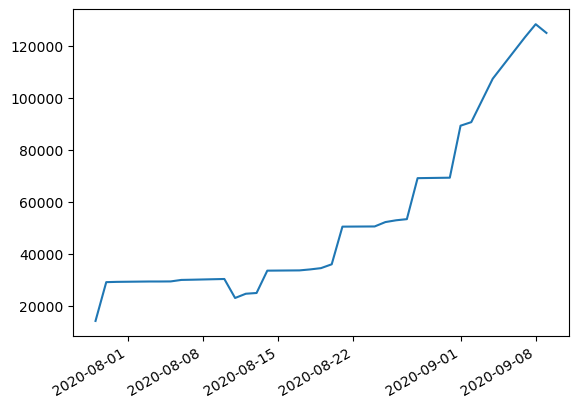

In [164]:
# calculate cumulative pnl
cum_pnl = pnl.cumsum()
cum_pnl.plot()

In [ ]:
print(train_date, date)
# locate the spread
spread.loc[train_date:date, :]